<a href="https://colab.research.google.com/github/esauresndiz/NASA-Turbofan-Jet-Engine/blob/main/Modelado_ML_supervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Entrega  Proyecto Final </h1>



Integrantes del equipo:


*   Miguel Ángel Verdi
*   Jorge Esaú Reséndiz
*   Miguel Villalobos
*   José Pablo González
*   Gerardo Pájaro

# Algoritmos de Machine Learning

Los algoritmos de machine learning son potentes herramientas quenos permiten aprender de los datos, hacer predicciones y/o tomar decisiones. Se utilizan ampliamente en diversos campos para resolver problemas complejos y descubrir patrones en grandes conjuntos de datos. Estos algoritmos pueden aplicarse a tareas como la clasificación, la regresión, la agrupación, entre otras. Mediante el análisis de datos históricos, los modelos de aprendizaje automático pueden predecir resultados futuros, detectar anomalías, automatizar procesos de toma de decisiones y personalizar experiencias de usuario. La elección del algoritmo depende del problema específico, la naturaleza de los datos y el resultado deseado, lo que convierte al machine learning en una tecnología versátil y de gran valor en cualquier sector que se aplique.

---
\
La implementación de algoritmos de machine learning es la parte fundamental de nuestro proyecto.

El objetivo de la implementación de estos algoritmos en nuestro proyecto, es poder **predecir en base a nuestros datos de entrada, el número de ciclos restantes** que le queda a cada uno de los 100 motores que han sido simulados, para poder asegurar la eficacia de estos algoritmos, contamos con una base de datos donde se tienen los valores reales para esos motores específicos.

La implementación de los algoritmos, es útil al momento de que se busque predecir nuevos cicos de vida restante para algunos otros motores que tengan diferentes características que los que aquí se han probado.

In [3]:
#Importamos nuestra base de datos
import pandas as pd
import numpy as np

df_train = pd.read_csv('df_train.csv')


* Datos de validación

También es importante importar los datos de validación que están en la base de datos inicial, para así poder revisar la eficiencia de nuestros algoritmos.

In [4]:
headers = [
    'unit_number', 'time', 'opSet1', 'opSet2', 'opSet3',
    'senMes1', 'senMes2', 'senMes3', 'senMes4', 'senMes5',
    'senMes6', 'senMes7', 'senMes8', 'senMes9', 'senMes10',
    'senMes11', 'senMes12', 'senMes13', 'senMes14', 'senMes15',
    'senMes16', 'senMes17', 'senMes18', 'senMes19', 'senMes20',
    'senMes21'
]

df_validation_FD001 = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=headers)
y_validation_FD001 = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

Para la validación se toma solamente el ultimo dato del data set

In [5]:


rows = []

for unit_number in df_validation_FD001['unit_number'].unique():
    df_max_cycles = df_validation_FD001[df_validation_FD001['unit_number'] == unit_number]
    mx_time = df_max_cycles['time'].max()

    new_row = df_max_cycles[df_max_cycles['time'] == mx_time].values
    rows.append(new_row[0])


df_validation_FD001_max = pd.DataFrame(rows, columns=headers)


* Funcion para agregar el RUL a cada fila del data set, usando el tiempo maximo encontrado.
* train será el data set con el que se entranará y evaluará la red haciendo un split 30-70.

In [6]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number')
    max_time_cycles = train_grouped_by_unit['time'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time']
    merged = merged.drop("max_time_cycle", axis=1)
    return merged
train = add_RUL_column(df_train)

<h1> Analisis y selección de variables de entrada </h1>

La selección de variables de entrada para los algoritmos es muy importante, la correcta selección para los inputs de nuestros algoritmos hará que no se ocupe tanto poder computacional, y así poder ahorra recursos.

* Se hace un plot entre los sensores y el RUL para visualizar su relación, esto en los data set FD001 y FD003, para poder revisar cuales son las variables con mayor relevancia.

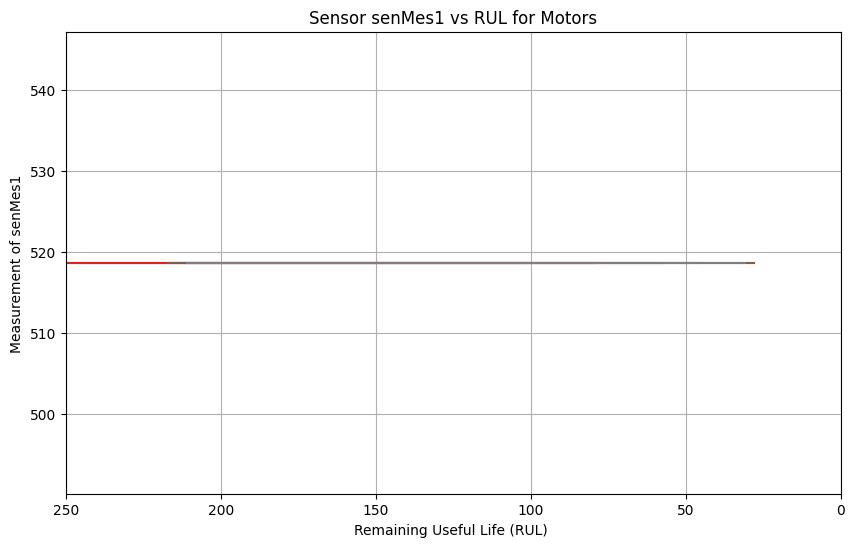

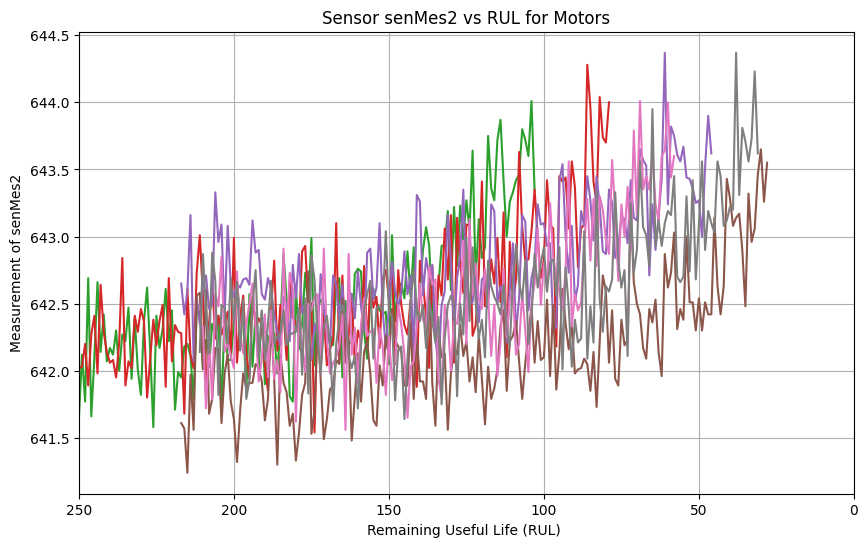

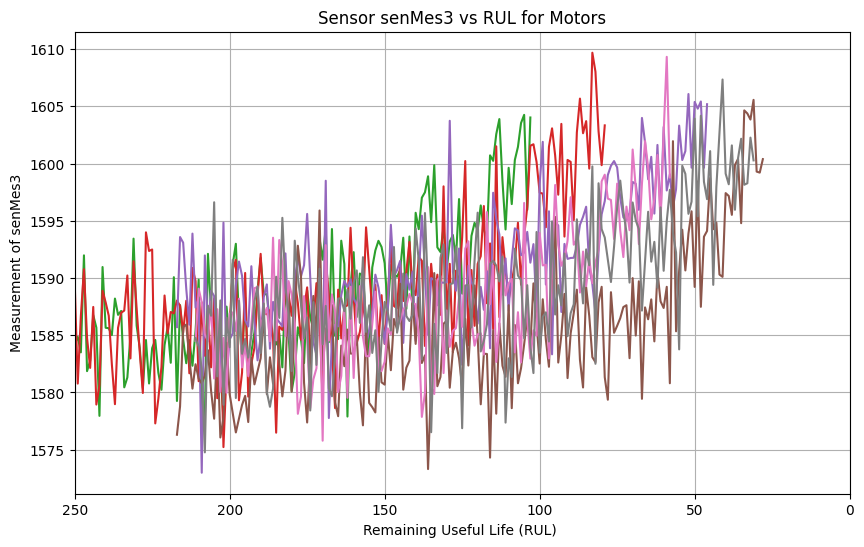

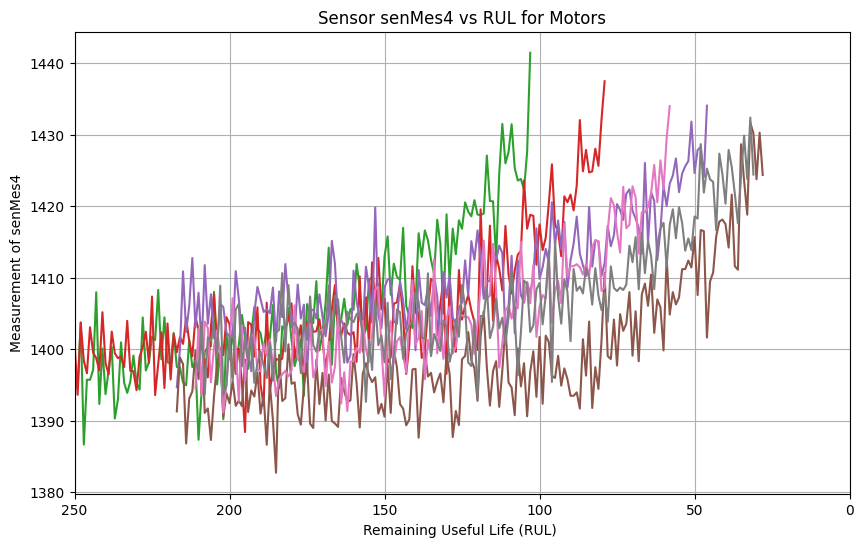

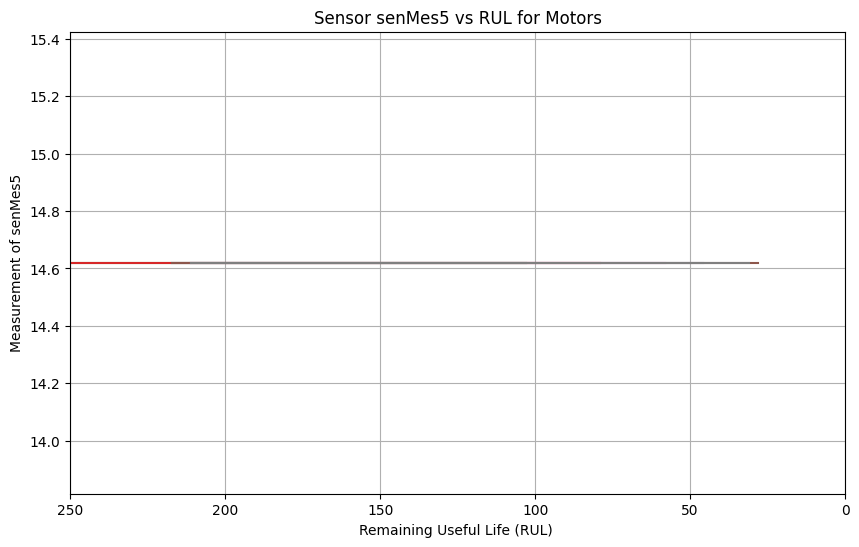

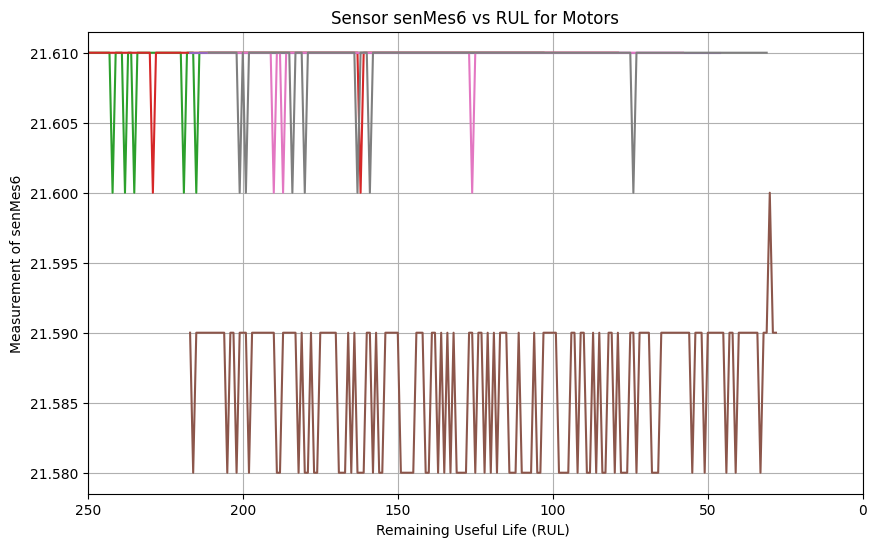

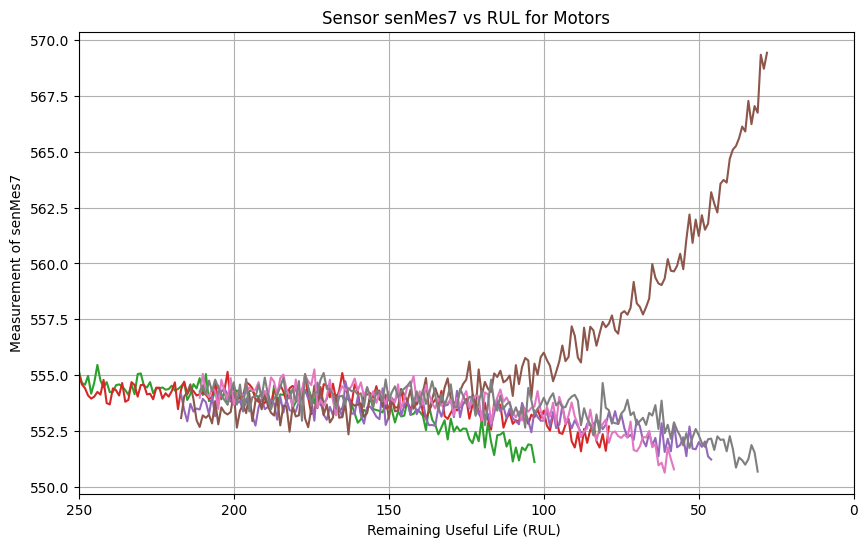

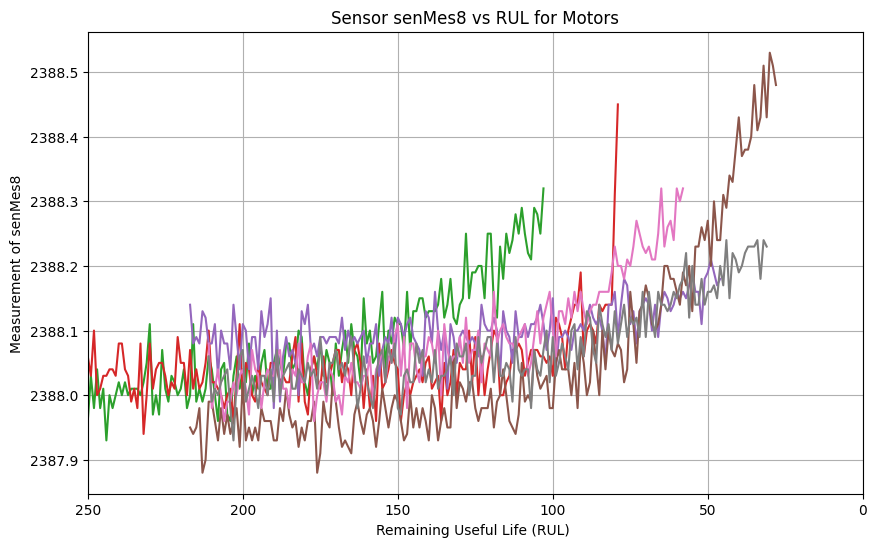

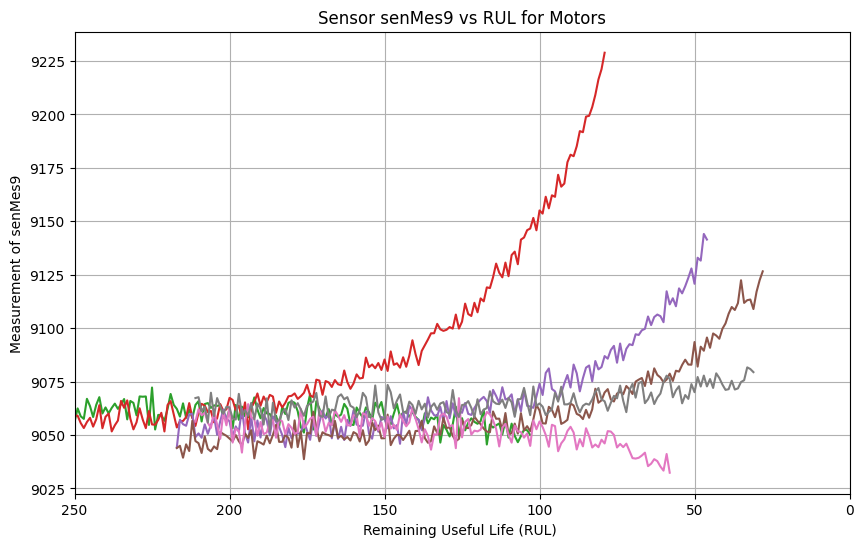

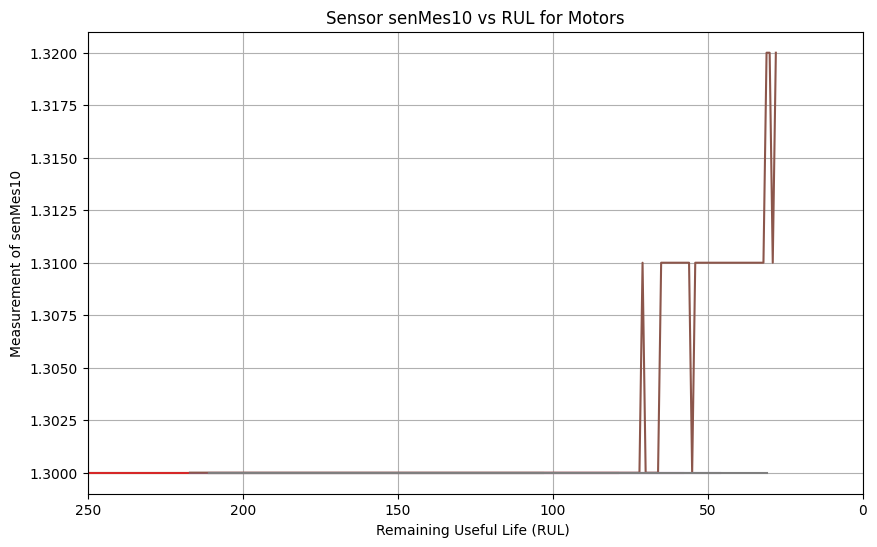

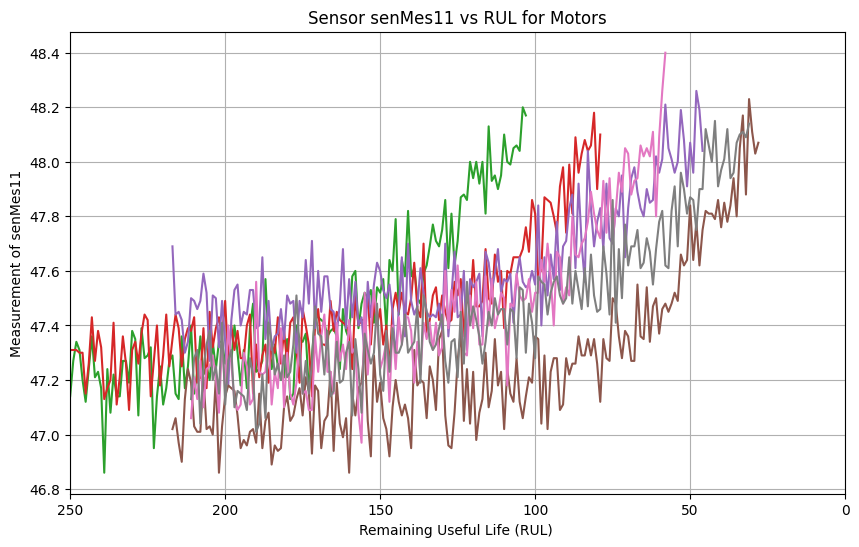

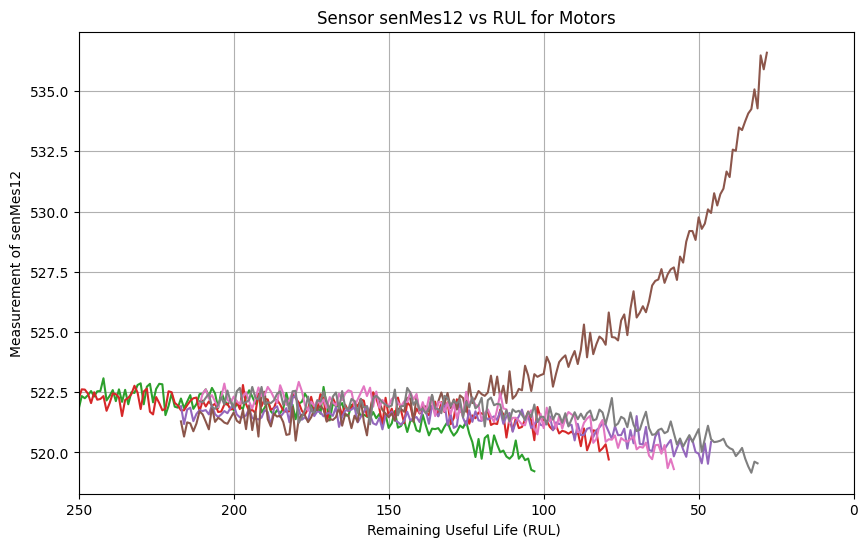

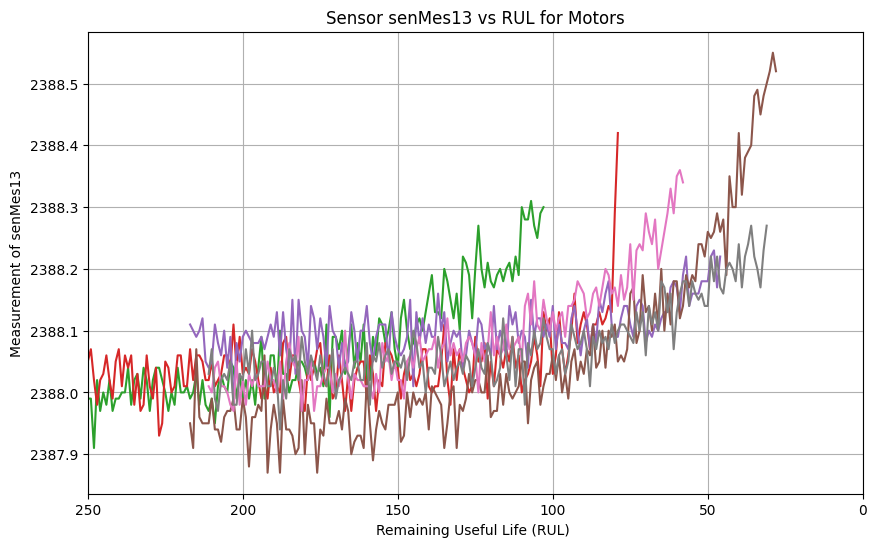

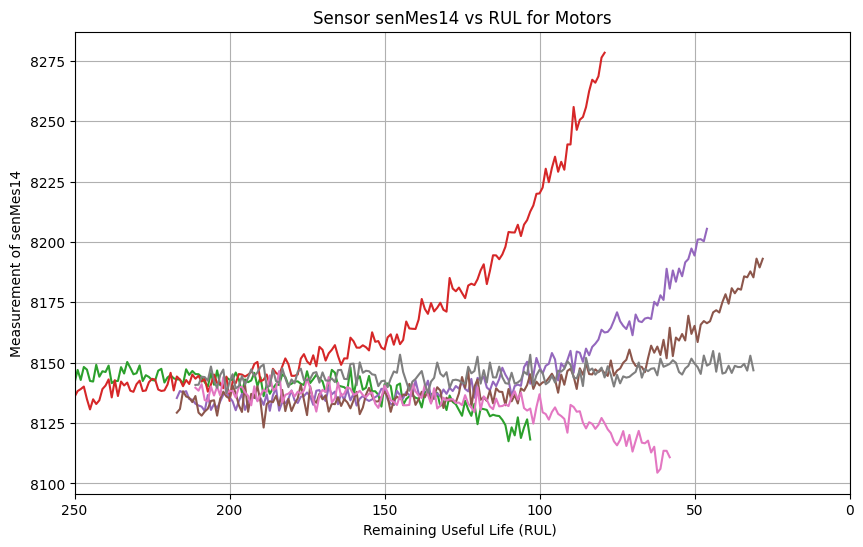

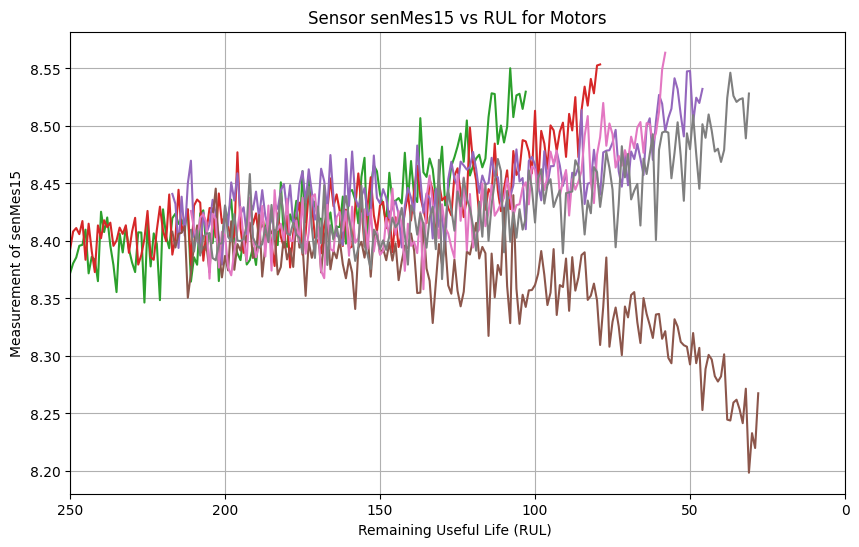

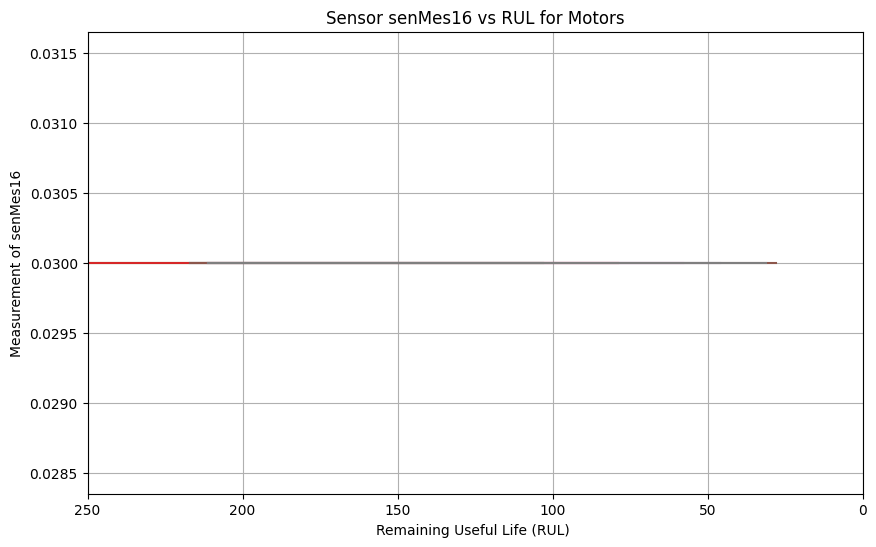

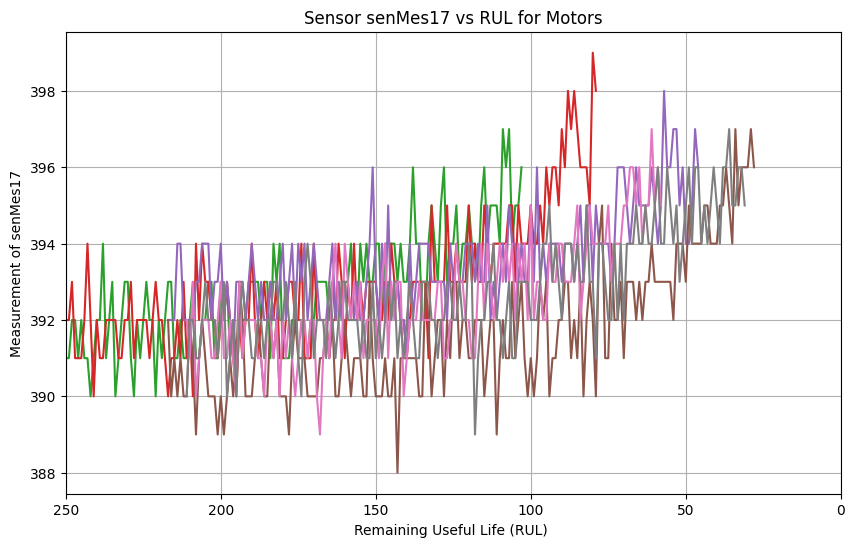

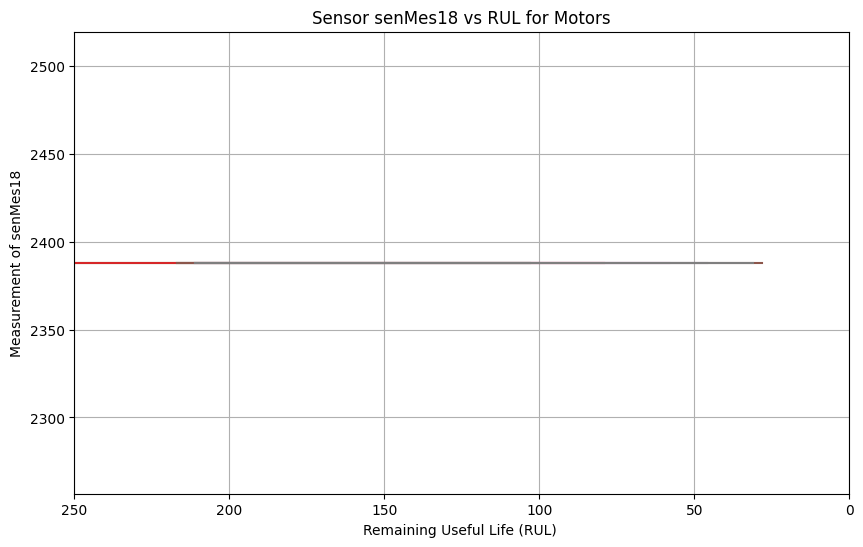

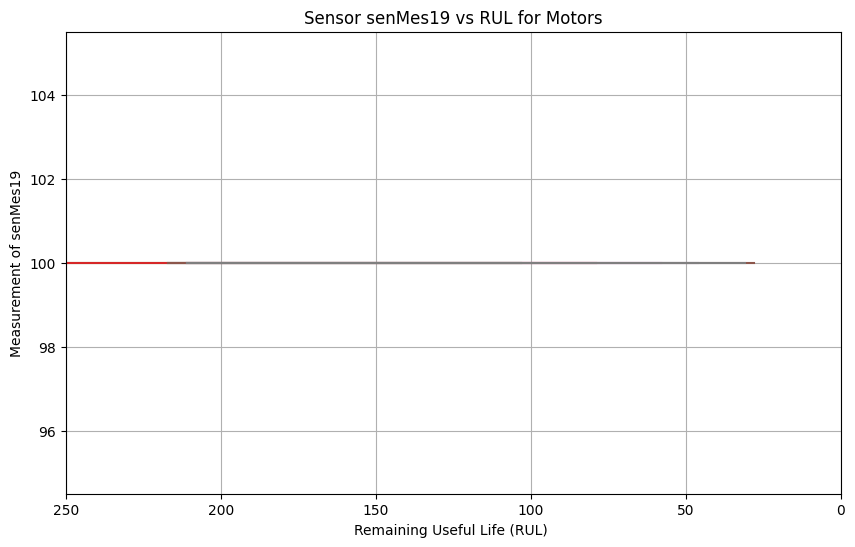

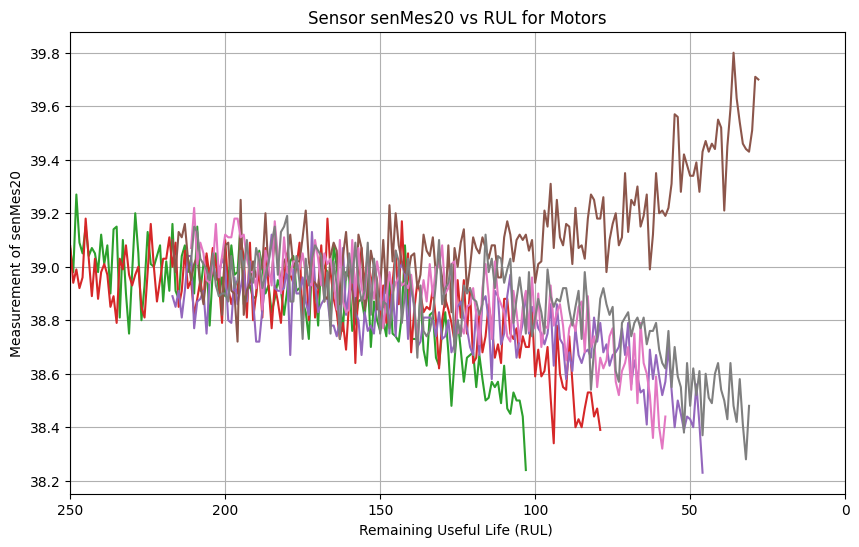

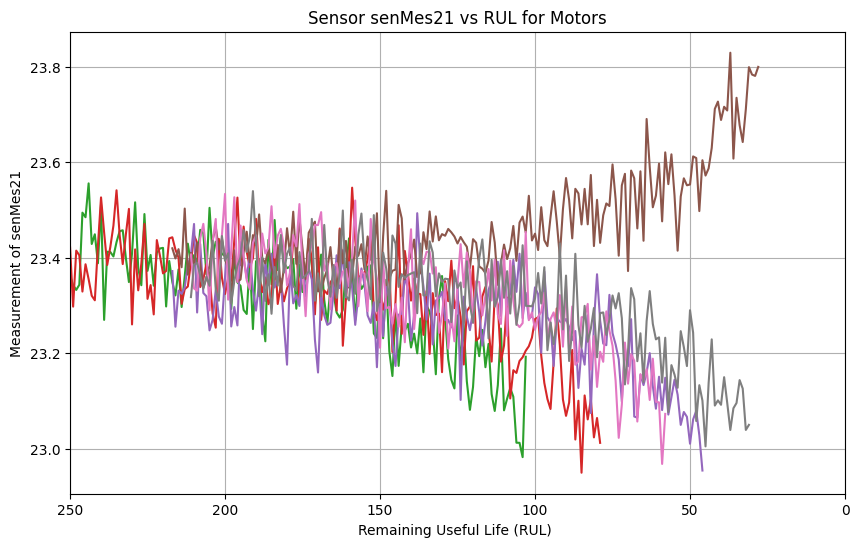

In [7]:
import matplotlib.pyplot as plt

plotHeaders = [
    'senMes1', 'senMes2', 'senMes3', 'senMes4', 'senMes5',
    'senMes6', 'senMes7', 'senMes8', 'senMes9', 'senMes10',
    'senMes11', 'senMes12', 'senMes13', 'senMes14', 'senMes15',
    'senMes16', 'senMes17', 'senMes18', 'senMes19', 'senMes20',
    'senMes21'
]


def plot_signal(df, sensor):

    plt.figure(figsize=(10, 6))
    sample = np.arange(0, 101, 30)

    for motor_number in sample:
        motor = df[(df['unit_number']== motor_number) & (df['dataSet']== 'FD001')]
        x = motor[sensor].values
        y = motor['RUL'].values
        text = "Data set FD001"
        plt.plot(y,x, label = text)

        motor = df[(df['unit_number']==motor_number) & (df['dataSet']== 'FD003')]
        x = motor[sensor].values
        y = motor['RUL'].values
        text = "Data set FD003"
        plt.plot(y,x, label = text)


    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.ylabel(f'Measurement of {sensor}')
    plt.xlabel('Remaining Useful Life (RUL) ')
    plt.title(f'Sensor {sensor} vs RUL for Motors')
    plt.grid(True)
    plt.show()



for i in range(0,21):
    plot_signal(train, plotHeaders[i])

* Para propositos de entrenamiento se ve que algunos sensores como el 1,5,6,10, etc no tienen un aporte al RUL y se descartan junto a las otras caracteristicas

In [8]:
from sklearn.model_selection import train_test_split

drop_labels = [
    'unit_number', 'time', 'opSet1', 'opSet2', 'opSet3',
    'senMes1', 'senMes5', 'senMes6', 'senMes10', 'senMes16',
    'senMes18','senMes19', 'FM', 'conditions',  'dataSet'
    ]

Train=train.drop(columns=drop_labels).copy()

* Split de datos en sets para entrenamiento  y para test.

In [9]:
X_train, X_test, y_train, y_test=train_test_split(Train,Train['RUL'], test_size=0.3, random_state=42)

X_test=X_test.drop(columns='RUL').copy()

X_train=X_train.drop(columns='RUL').copy()


* Escalado de datos usando MinMaxScaler

In [10]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)


* Histogramas del comportamiento de los sensores

array([[<Axes: title={'center': 'senMes2'}>,
        <Axes: title={'center': 'senMes3'}>,
        <Axes: title={'center': 'senMes4'}>,
        <Axes: title={'center': 'senMes7'}>],
       [<Axes: title={'center': 'senMes8'}>,
        <Axes: title={'center': 'senMes9'}>,
        <Axes: title={'center': 'senMes11'}>,
        <Axes: title={'center': 'senMes12'}>],
       [<Axes: title={'center': 'senMes13'}>,
        <Axes: title={'center': 'senMes14'}>,
        <Axes: title={'center': 'senMes15'}>,
        <Axes: title={'center': 'senMes17'}>],
       [<Axes: title={'center': 'senMes20'}>,
        <Axes: title={'center': 'senMes21'}>, <Axes: >, <Axes: >]],
      dtype=object)

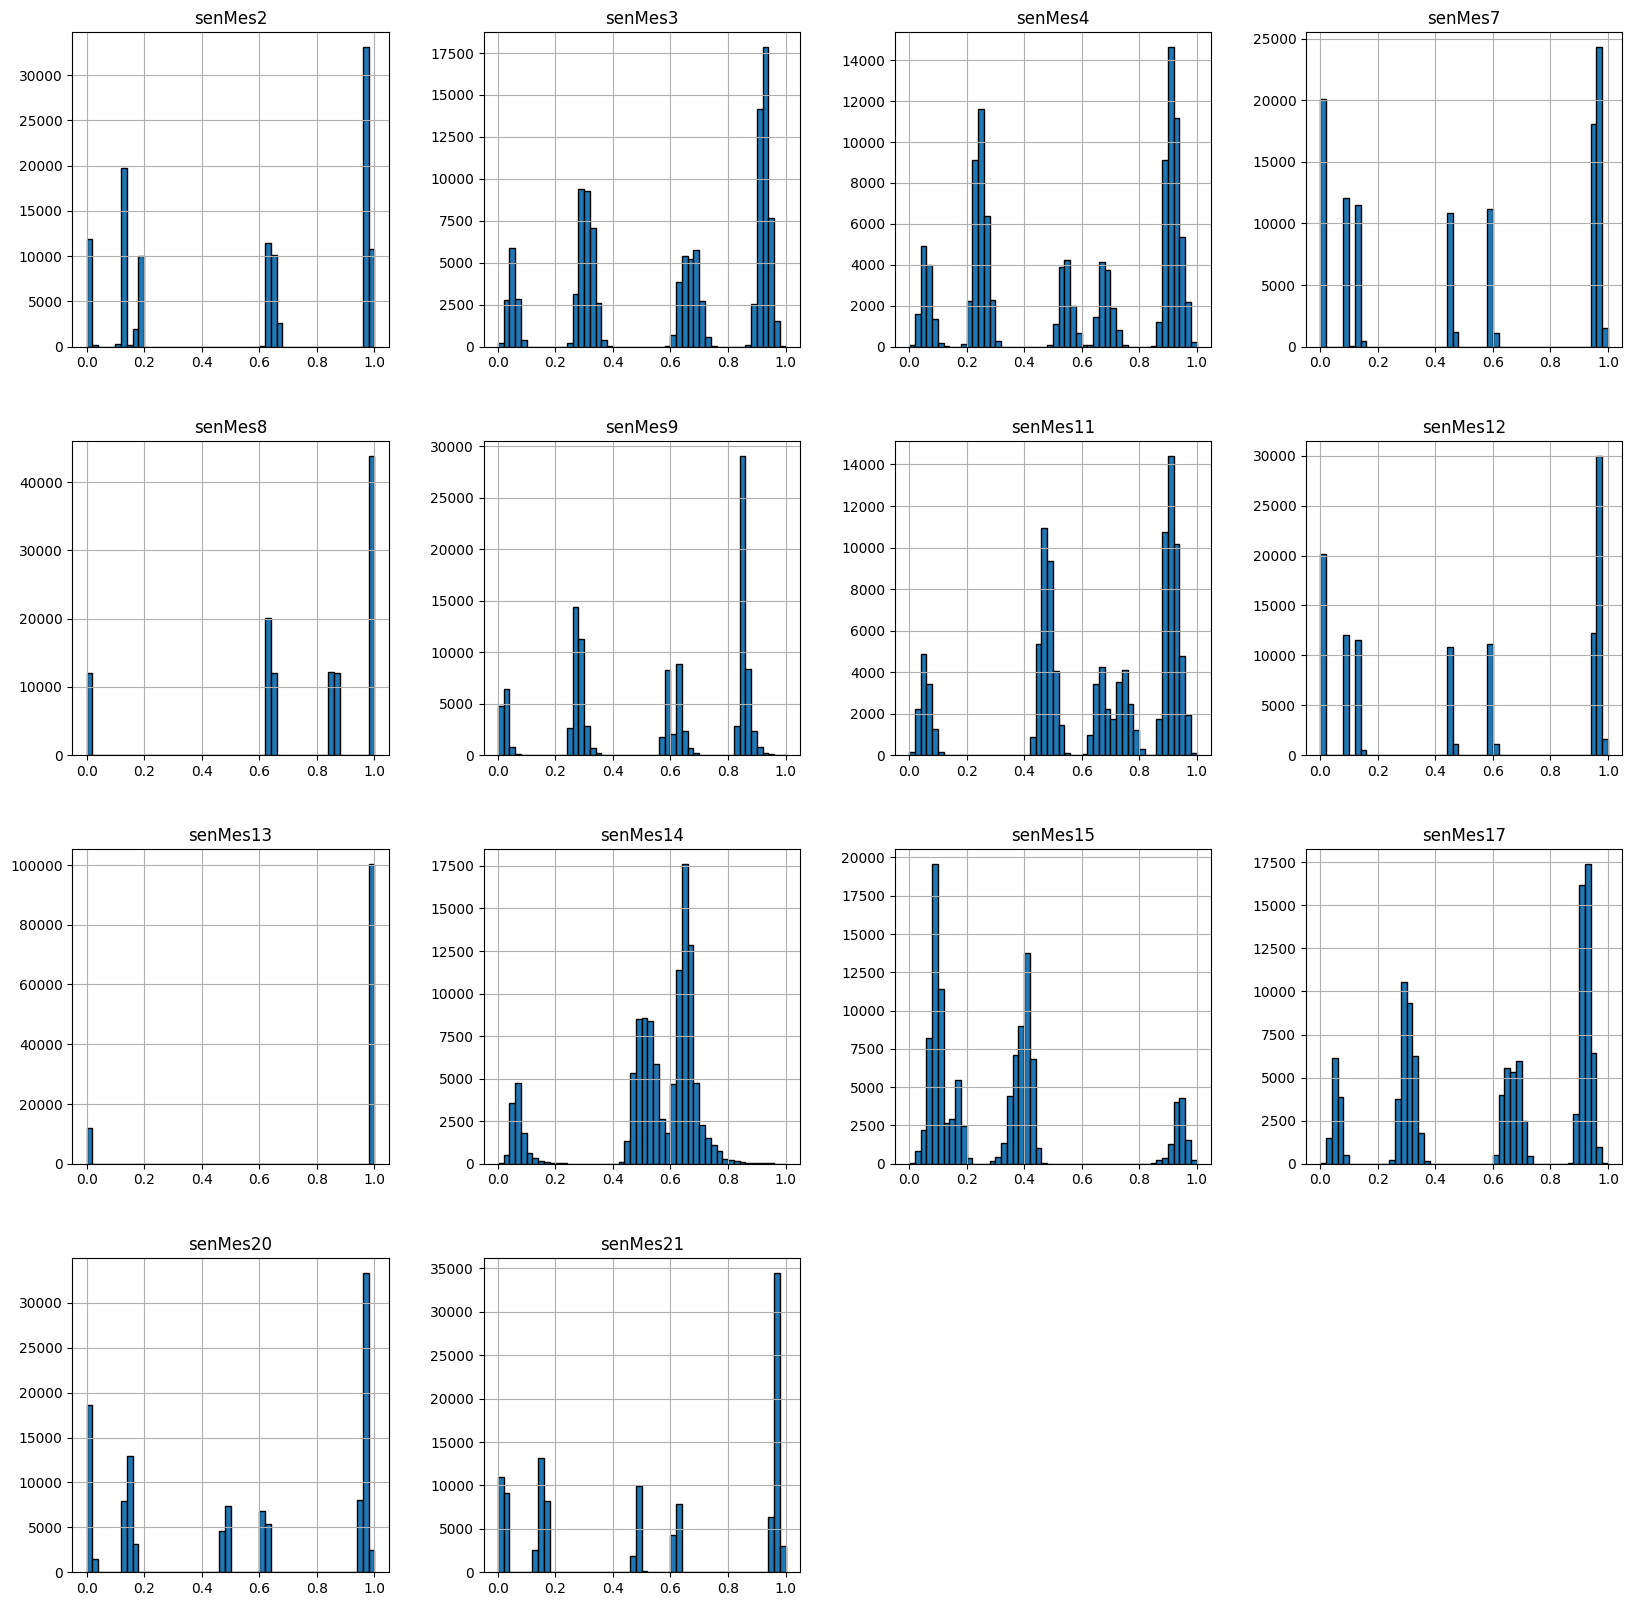

In [11]:
X_train.hist(figsize=(20, 20), bins=50, edgecolor='black')

<h1> Entrenamiento utilizando Random Forest </h1>

El algoritmo Random Forestnos puede ser útil para un problema de regresión o clasificación, especialmente cuando se trata de conjuntos de datos complejos con muchas características y posibles relaciones no lineales, el cuál es un caso bastante parecido a nuestro set de datos.

Elegir un random forest ofrece varias ventajas, pueden modelar eficazmente relaciones complejas y no lineales entre las características de entrada y la predicción requerida, lo que los hace idóneos para una amplia gama de problemas de predicción. Son capaces de realizarlas precisas con relativamente poco tiempo de entrenamiento, incluso con grandes conjuntos de datos. También ofrecen la ventaja de manejar datos numéricos y categóricos a la perfección, lo que permite un uso versátil en diferentes escenarios. Esto los convierte en una opción excelente para el modelado predictivo.


*  Busqueda exhaustiva de hiperparametros para entrenar posteriormente un modelo de random forest

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()
param_grid = {
    'n_estimators': [50,90,120],
    'max_depth' : [8,9,10],
}

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3)

grid.fit(X_train, y_train)

print(grid.best_score_ , grid.best_params_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


0.4018426158530879 {'max_depth': 10, 'n_estimators': 90}


* Utilizando los parametros encontrados, hacemos el randomForest

* Declaramos una función de evaluación

In [12]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rf=RandomForestRegressor(n_estimators=120,  max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_hat_train = rf.predict(X_train)
evaluate(y_train,y_hat_train, label='train')
y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test, label='test')


train set RMSE:71.31014821764435, R2:0.4470587669899656
test set RMSE:77.06444195910626, R2:0.3525079419609761


* Visualización de los features más relevantes para el calculo de RUL

<BarContainer object of 14 artists>

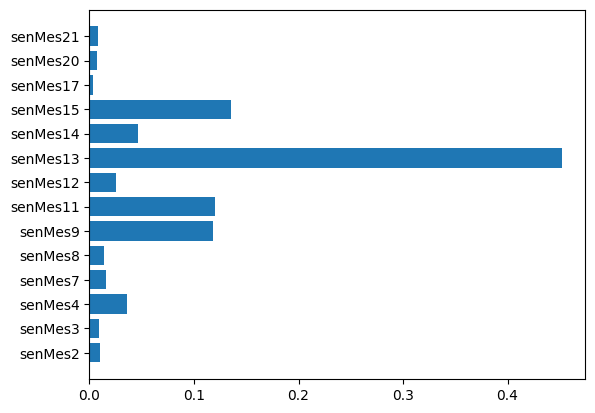

In [16]:
import pandas as pd
plt.barh(X_train.columns, rf.feature_importances_)

* Se entrenará el modelo solo con el sensor 15,14,13,12,11,9,8,7 y 4

In [17]:
selected_features_rf = ['senMes15','senMes14','senMes13','senMes12', 'senMes11', 'senMes9' ,'senMes8', 'senMes7', 'senMes4' ]
X_train_rf = X_train[selected_features_rf]
X_test_rf = X_test[selected_features_rf]


* Se entrena el modelo de nuevo con los sensores selccionados
* De nuevo se estimas los mejores parametros

In [18]:
estimator = RandomForestRegressor()
param_grid = {
    'n_estimators': [50,90,120],
    'max_depth' : [8,9,10],
}

grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3)

grid.fit(X_train_rf, y_train)

print(grid.best_score_ , grid.best_params_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


0.4016720822769498 {'max_depth': 10, 'n_estimators': 120}


* De nuevo se entrena la red con random Forest y los parametros obtenidos

In [28]:
rf=RandomForestRegressor(n_estimators=120,  max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_train_rf, y_train)

y_hat_train = rf.predict(X_train_rf)
evaluate(y_train,y_hat_train, label='train')
y_hat_test = rf.predict(X_test_rf)
evaluate(y_test, y_hat_test, label='test')



train set RMSE:71.5571871896325, R2:0.443221034360454
test set RMSE:76.94642131472354, R2:0.35448963191015814


In [29]:
print(X_train_rf)

        senMes15  senMes14  senMes13  senMes12  senMes11   senMes9   senMes8  \
0       0.415120  0.466692  0.992533  0.133706  0.485188  0.283799  0.649941   
1       0.119003  0.669465  0.993607  0.959920  0.939151  0.864461  0.998966   
2       0.095533  0.674264  0.993304  0.960897  0.919936  0.859350  0.998734   
3       0.940584  0.080055  0.002039  0.088519  0.076861  0.024403  0.001519   
4       0.423918  0.500714  0.992946  0.004081  0.439552  0.257555  0.627152   
...          ...       ...       ...       ...       ...       ...       ...   
112246  0.387526  0.466089  0.993773  0.455032  0.699760  0.579281  0.863690   
112247  0.944261  0.042662  0.001240  0.087956  0.055244  0.017277  0.000717   
112248  0.391168  0.457695  0.992808  0.130432  0.436349  0.281522  0.649962   
112249  0.924433  0.039202  0.001185  0.085341  0.019215  0.009928  0.000950   
112250  0.170825  0.656941  0.993304  0.596559  0.730184  0.635087  0.852654   

         senMes7   senMes4  
0       0.

<BarContainer object of 9 artists>

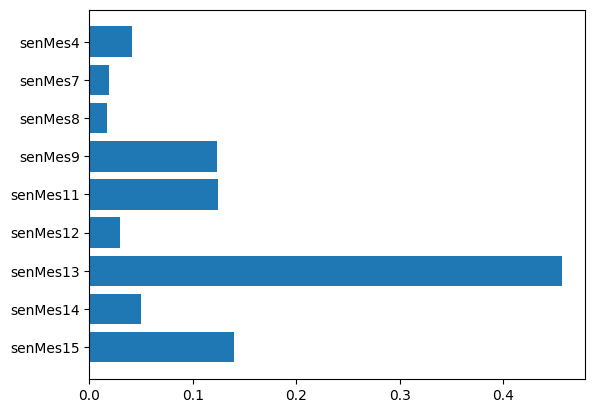

In [30]:
plt.barh(X_train_rf.columns, rf.feature_importances_)

* Se utiliza el data set de validación que es dado por el repositorio de datos de la NASA con el RUL verdadero para datos que no ha visto el algoritmo

In [31]:
selected_features = ['senMes15', 'senMes14', 'senMes13', 'senMes12', 'senMes11', 'senMes9', 'senMes8', 'senMes7', 'senMes4']

validation_rf_FD001 = df_validation_FD001_max[selected_features]

scaler = MinMaxScaler()
validation_rf_FD001  = pd.DataFrame(scaler.fit_transform(validation_rf_FD001 ), columns=validation_rf_FD001 .columns)

y_hat_valid_rf = rf.predict(validation_rf_FD001)
evaluate(y_validation_FD001, y_hat_valid_rf, label='test')

test set RMSE:79.67021310673871, R2:-2.6756352978089155


<ipython-input-32-2e65ab6574c3>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_values = [int(x) for x in y_test.values]


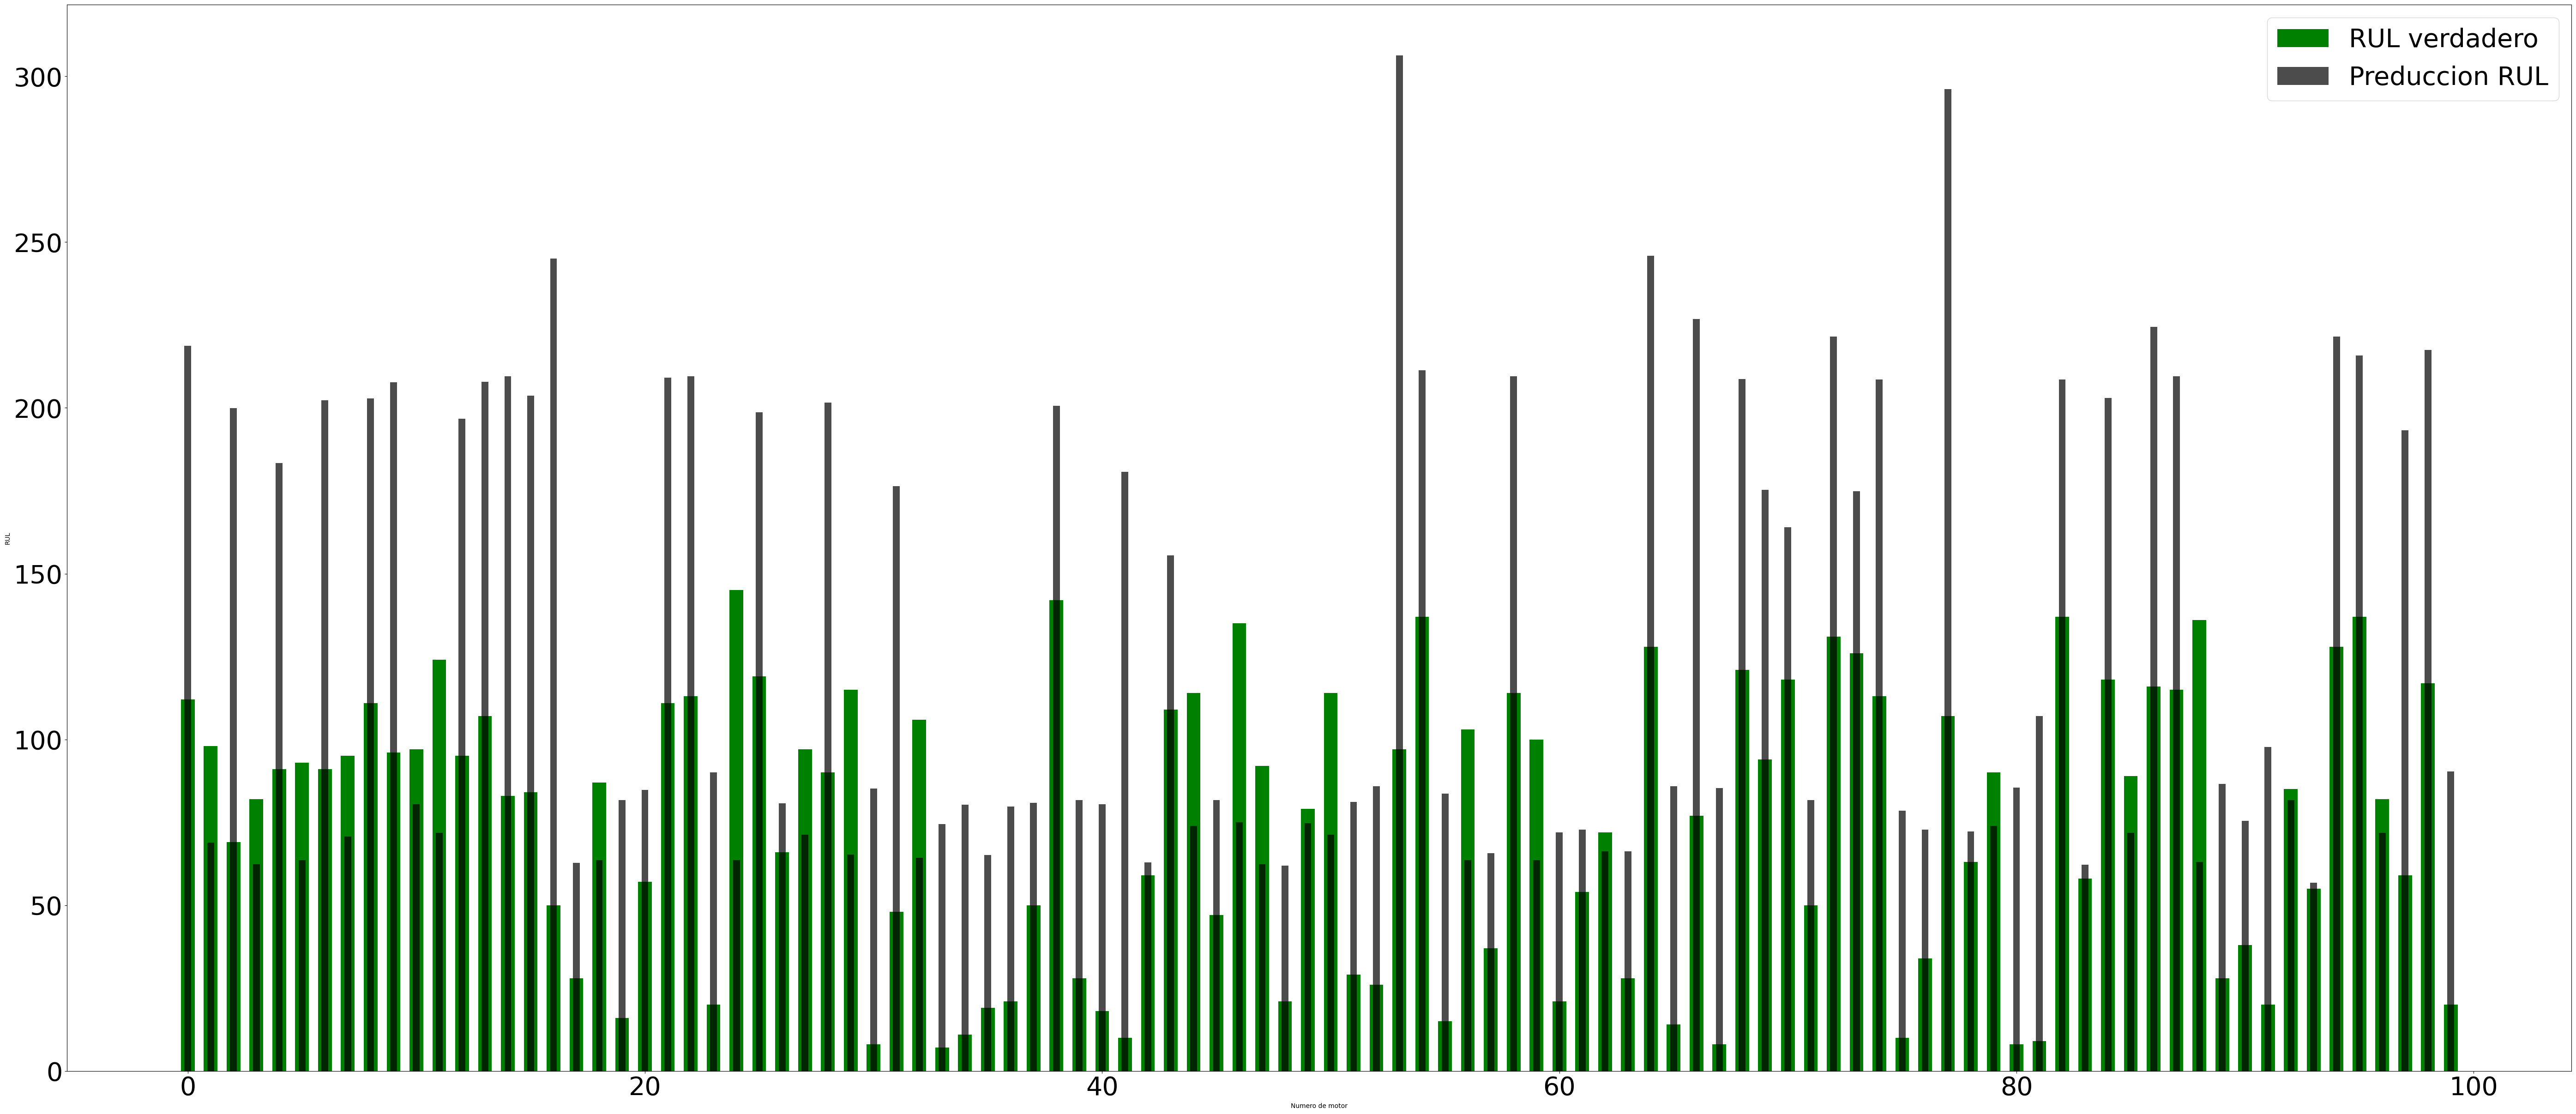

In [32]:
def plot_predActual(y_test, y_test_hat):

    indices = np.arange(len(y_test_hat))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='g', label='RUL verdadero')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='k', alpha=0.7, label='Preduccion RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)
    plt.xlabel('Numero de motor')
    plt.ylabel('RUL')
    plt.show()

plot_predActual(y_validation_FD001, y_hat_valid_rf)


<h1> Entrenamiento con regresión lineal </h1>

train set RMSE:82.1273103435958, R2:0.2665821116867456
test set RMSE:84.17996605169917, R2:0.2274192861668699


<BarContainer object of 14 artists>

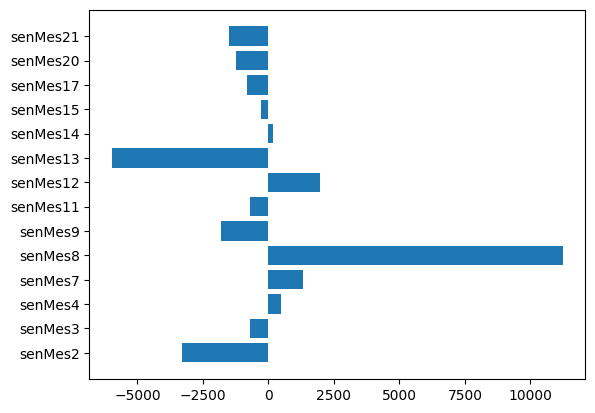

In [57]:
from sklearn.linear_model import LinearRegression

#variables para que esau use:
#Entrenamiento:  X_train y_train, X_test, y_test (vienen ya escaladas, en 70-30)

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

modelLR = LinearRegression()
modelLR.fit(X_train_s,y_train)



y_hat_train_LR = modelLR.predict(X_train_s)
evaluate(y_train,y_hat_train_LR, label='train')


y_hat_test_LR = modelLR.predict(X_test_s)
evaluate(y_test, y_hat_test_LR, label='test')
plt.barh(X_train.columns, modelLR.coef_)

* Seleccion de features

train set RMSE:85.36226326038192, R2:0.20766627638774215
test set RMSE:88.49339074949633, R2:0.1462159405933241


<BarContainer object of 8 artists>

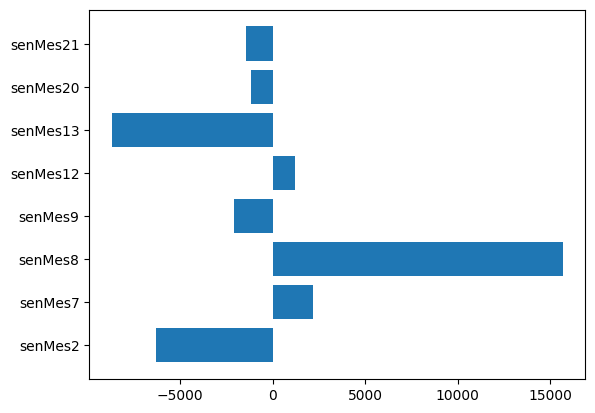

In [58]:
selected_features = ['senMes2', 'senMes7', 'senMes8', 'senMes9', 'senMes12', 'senMes13', 'senMes20', 'senMes21']


X_train_LR =  X_train[selected_features]
X_test_LR =  X_test[selected_features]

modelLR2 = LinearRegression()
modelLR2.fit(X_train_LR,y_train)


y_hat_train_LR = modelLR2.predict(X_train_LR)
evaluate(y_train,y_hat_train_LR, label='train')

y_hat_test_LR = modelLR2.predict(X_test_LR)
evaluate(y_test, y_hat_test_LR, label='test')

plt.barh(X_train_LR.columns, modelLR2.coef_)

* Validación con data set real de la nasa

In [59]:
selected_features = ['senMes2', 'senMes7', 'senMes8', 'senMes9', 'senMes12', 'senMes13', 'senMes20', 'senMes21']
validation_LR_FD001 = df_validation_FD001_max[selected_features]
scaler = MinMaxScaler()
validation_LR_FD001  = pd.DataFrame(scaler.fit_transform(validation_LR_FD001 ), columns=validation_LR_FD001 .columns)



y_hat_valid_lr = modelLR2.predict(validation_LR_FD001)
evaluate(y_validation_FD001, y_hat_valid_lr, label='test')


test set RMSE:1893.1162962948215, R2:-2074.367654452324


<ipython-input-60-2e65ab6574c3>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_values = [int(x) for x in y_test.values]


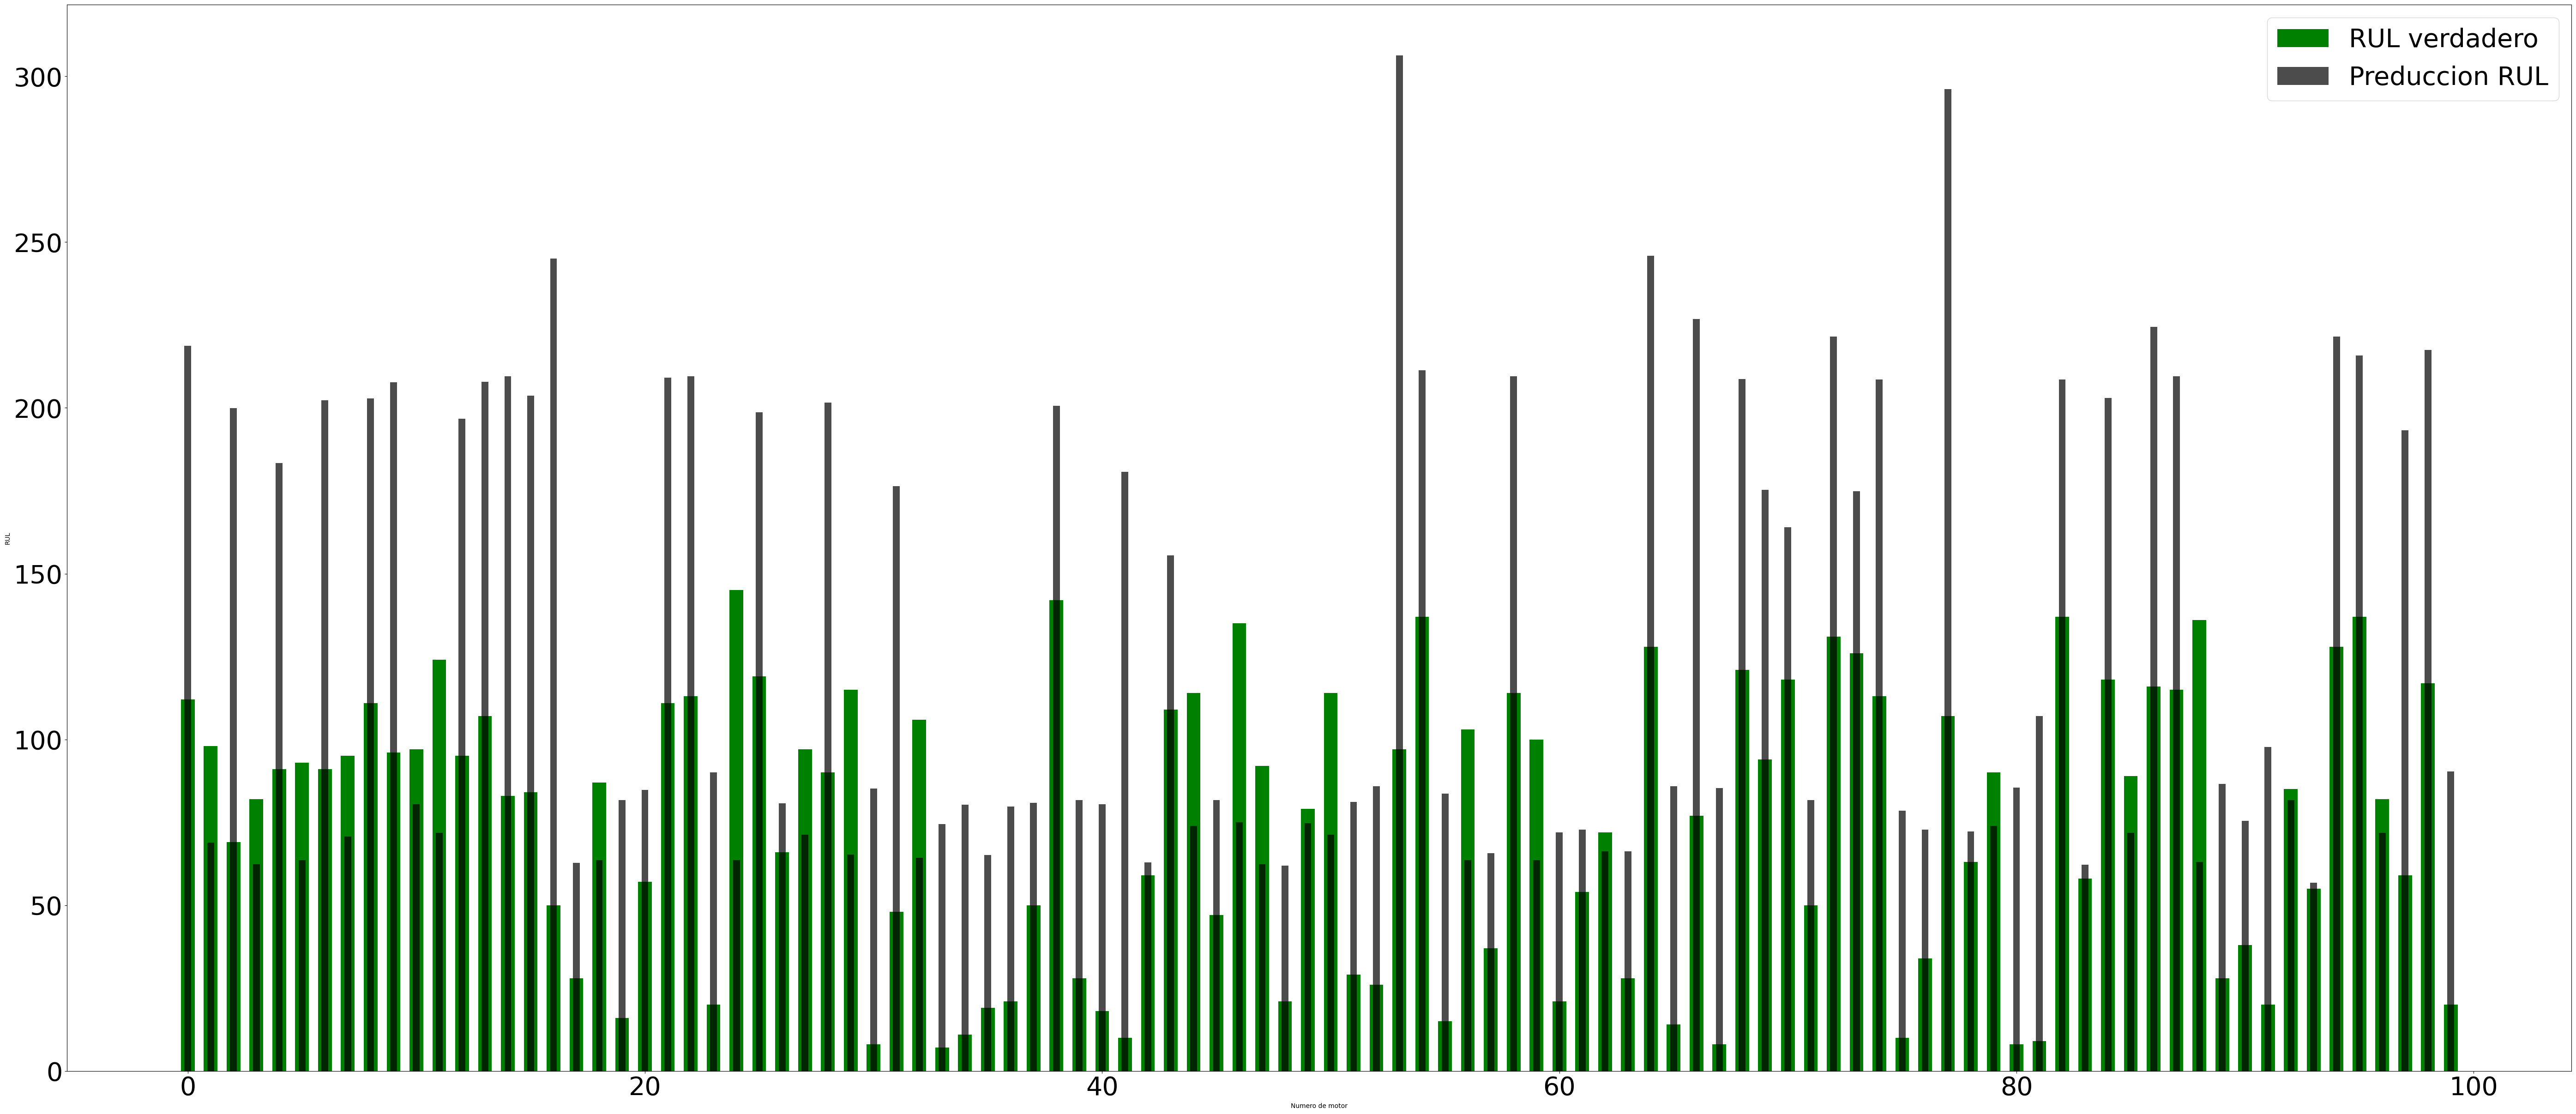

In [60]:
def plot_predActual(y_test, y_test_hat):

    indices = np.arange(len(y_test_hat))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='g', label='RUL verdadero')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='k', alpha=0.7, label='Preduccion RUL')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)
    plt.xlabel('Numero de motor')
    plt.ylabel('RUL')
    plt.show()

plot_predActual(y_validation_FD001, y_hat_valid_rf)

# Modelo de Deep Learning

<h1> Entrenamiento con Red Neuronal usando Keras </h1>

* Entrenamiento utilizando keras

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Creamos variables locales para el entrenamiento
X_val = df_validation_FD001_max.copy()
y_val = validation_rf_FD001.copy()


model = Sequential()
model.add(Dense(10, input_dim=14, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(), loss='mean_squared_error')

model.summary()
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=1)
loss_test = model.evaluate(X_test, y_test, verbose=0)
print(f'Loss en el conjunto de prueba: {loss}')

# Predicciones en el conjunto de prueba
y_pred_test = model.predict(X_test)

# Evaluación en el conjunto de validación
loss_val = model.evaluate(X_val, y_val, verbose=0)
print(f'Loss en el conjunto de validación: {loss_val}')

# Predicciones en el conjunto de validación
y_pred_val = model.predict(X_val)
y_pred = model.predict(X_test)

NameError: name 'df_validation_FD001_max' is not defined

* Plot del loss en primer entrenamiento

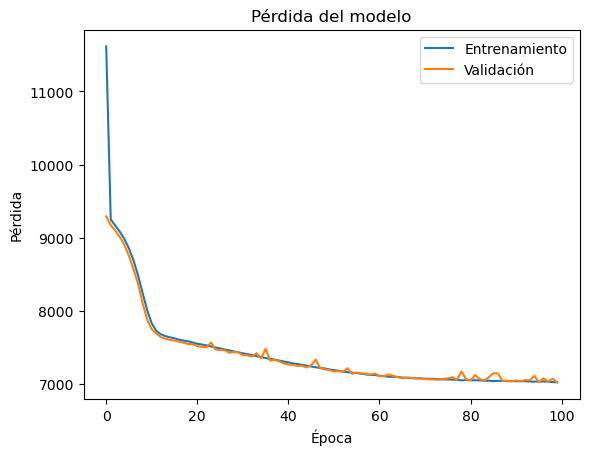

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.show()

* Seleccion de features con mas importancia

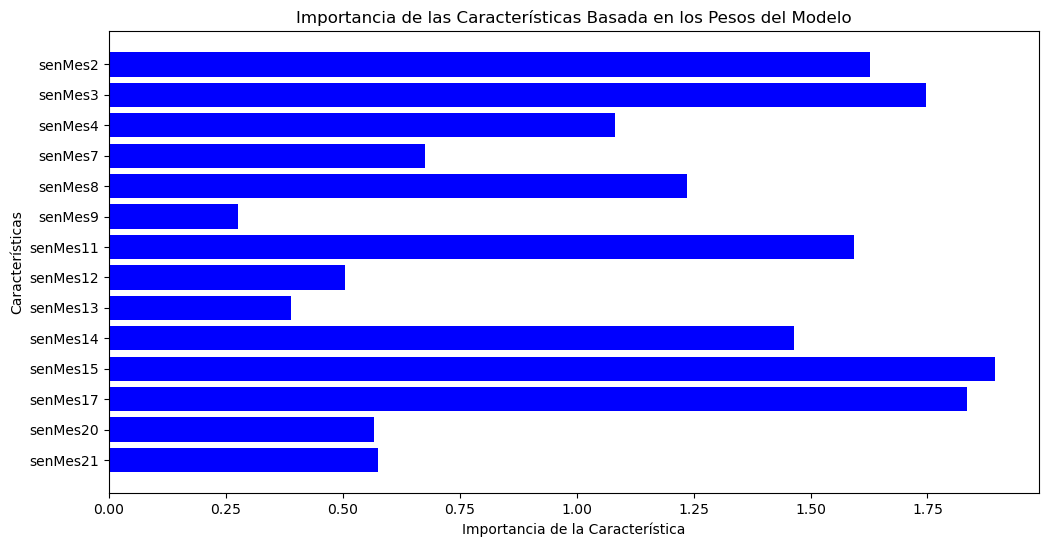

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

weights = model.layers[0].get_weights()[0]
importance = np.abs(weights).mean(axis=1)

def plot_feature_importance_from_weights(importance, feature_names):
    indices = np.arange(len(importance))
    plt.figure(figsize=(12, 6))
    plt.barh(indices, importance, color='b', align='center')
    plt.xlabel('Importancia de la Característica')
    plt.ylabel('Características')
    plt.title('Importancia de las Características Basada en los Pesos del Modelo')
    plt.yticks(indices, feature_names)
    plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté arriba
    plt.show()

plot_feature_importance_from_weights(importance, X_test.columns)

* Plot del loss

In [ ]:

selected_features = ['senMes2','senMes3','senMes4','senMes7','senMes8','senMes11','senMes14','senMes15','senMes17']


X_train_seq = X_train[selected_features]
X_test_seq = X_test[selected_features]


modelseq = Sequential()
modelseq.add(Dense(10, input_dim=9, activation='relu'))
modelseq.add(Dense(5, activation='relu'))
modelseq.add(Dense(1))

modelseq.compile(optimizer=Adam(), loss='mean_squared_error')
modelseq.summary()

history = modelseq.fit(X_train_seq, y_train, epochs=50, batch_size=10, validation_split=0.2, verbose=1)
loss = modelseq.evaluate(X_test_set, y_test, verbose=0)
print(f'Loss en el conjunto de prueba: {loss}')

y_pred = modelseq.predict(X_test_seq)

C:\Users\Verdi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 10)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 161 (644.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8924/8980 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 15618.4971